In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import qmc
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from sympy import prevprime
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def seed():
    np.random.seed(42)

seed()

In [3]:
np.diff(np.array([0,1,5,7,10]))

array([1, 4, 2, 3])

# Q1.Implement and visualize Mandelbrot set

In [4]:
class Mandelbrot():

    def __converges(self, cs, i_list: np.array):
        i_list_sorted = np.sort(i_list)
        num_i = len(i_list_sorted)
        num_s = len(cs)

        z = np.zeros(num_s, dtype=np.complex64)
        escape_times_i_list = np.zeros((num_i, num_s), dtype=np.uint16)
        conv_i_list = np.ones((num_i, num_s), dtype=bool)

        if num_i > 1:
            i_maxs = np.zeros(num_i, dtype=np.uint16)
            i_maxs[0] = i_list_sorted[0]
            i_maxs[1:] = np.round(np.diff(i_list_sorted))
        else: 
            i_maxs = i_list_sorted

        for idx in range(num_i):
            escape_times_i_list[idx] = escape_times_i_list[idx-1] if idx > 0 else escape_times_i_list[idx]
            conv_i_list[idx] = conv_i_list[idx-1] if idx > 0 else conv_i_list[idx]
            for _ in range(i_maxs[idx]):
                z[conv_i_list[idx]] = z[conv_i_list[idx]]**2 + cs[conv_i_list[idx]]
                mask_conv = (np.abs(z) > 2)
                conv_i_list[idx, mask_conv] = False
                escape_times_i_list[idx, conv_i_list[idx]] += 1

        return conv_i_list, escape_times_i_list

    def __get_rand_dist(self, num_points):
        """Generates random complex numbers with absolute value smaller or equal to 2, i.e. sample from the circle with radius 2."""
        grid = 2 * np.sqrt(np.random.uniform(size=num_points)) * np.exp(1.j * 2 * np.pi * np.random.uniform(size=num_points))
        
        return grid.astype(np.complex64)

    def __get_rand_LHS(self, num_points): 
        """Generates random complex numbers with LHS method"""
        samples = qmc.LatinHypercube(d=2, strength=1).random(n=num_points)
        grid = 2 * np.sqrt(samples[:,0]) * np.exp(1.j * 2 * np.pi * samples[:,1])

        return grid.astype(np.complex64)
    
    def __get_rand_Orth(self, num_points): 
        """Generates random complex numbers with Orth method"""
        sampler = qmc.LatinHypercube(d=2, strength=2).random(n=num_points)
        grid = 2 * np.sqrt(sampler[:,0]) * np.exp(1.j * 2 * np.pi * sampler[:,1])

        return grid.astype(np.complex64)
    
    def get_escape_time(self, num_points, i_list: np.array):
        grid = self.__get_rand_dist(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_LHS(self, num_points, i_list: np.array):
        grid = self.__get_rand_LHS(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_Orth(self, num_points, i_list: np.array):
        grid = self.__get_rand_Orth(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_MC(self, converges, final_area=np.pi * 4):
        MC_list = converges.sum(axis=-1) / np.size(converges, axis=-1) * final_area

        return MC_list

In [5]:
# mandelbrot = Mandelbrot()
# num_points = 10**7
# max_iter = np.array([3000])
# grid_draw, converges_draw, escape_times_draw = mandelbrot.get_escape_time(num_points, max_iter)
# mandelbrot.get_MC(converges_draw)

In [6]:
def has_no_converging_points(grid, converges, r, real_part):
    if real_part:
        condition = np.real(grid) > r
    else:
        condition = np.abs(np.imag(grid)) > r
    
    converging_points = np.logical_and(condition, converges)
    has_no_conv_points = not np.any(converging_points)
    
    if real_part:
        conv_bound = f'Real(c) > {r}'
    else:
        conv_bound = f'Im(c) > {r}'

    print(f'The statement when {conv_bound} there is a c in the Mandelbrot set is {has_no_conv_points}')

# has_no_converging_points(grid_draw, converges_draw, 0.5, True)
# has_no_converging_points(grid_draw, converges_draw, 1.15, False)

In [7]:
def plot_Mandelbrot(grid, escape_times):
    sns.set(style='whitegrid')
    colors = ['#00008B', 'white', 'black']
    cmap = LinearSegmentedColormap.from_list('blue_white_black', colors)

    fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

    # Set only the plot area background to blue
    ax.set_facecolor('#00008B')
    
    ax.scatter(np.real(grid), np.imag(grid), c=np.log(escape_times), cmap=cmap, s=0.01)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])

    def format_func(value, tick_number):
        return f'{value}i'

    ax.yaxis.set_major_formatter(FuncFormatter(format_func))

    ax.axvline(x=0.5, color='r', linestyle='--')
    ax.axhline(y=1.15, color='g', linestyle='--')
    ax.axhline(y=-1.15, color='b', linestyle='--')

    ax.set_xlabel('Re')
    ax.set_ylabel('Im')

    ax.set_title(f'Mandelbrot Set with {len(grid)} Uniform Points')
    ax.grid(False)

    plt.savefig(f'figures/Mandelbrot.png')

    plt.show()


In [8]:
# plot_Mandelbrot(grid_draw, escape_times_draw)

# Q2.Investigate the RMSE and convergence

Implementing LHS, OR method: 

In [9]:
def get_rmse(true_value, mc_data):
    return np.sqrt(((mc_data - true_value)**2).mean(axis=0))

def get_data_rs(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None, get_converges_grid=False):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_true_area_{num_mc}_random.npy', 'rb') as f:
            true_area = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{num_mc}_random.npy', 'rb') as f:
            rmse = np.load(f)
    
        if get_converges_grid:
            with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'rb') as f:
                converges_i_list = np.load(f)
            with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random.npy', 'rb') as f:
                grid = np.load(f)
            return areas, sd, upper_ci, lower_ci, converges_i_list, grid, true_area, rmse

        return areas, sd, upper_ci, lower_ci, true_area, rmse
        
    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    rmse = np.zeros((num_i, num_s))

    max_s = np.max(s_list)
    mc_data = None
    grid, converges_i_list, _ = mandelbrot.get_escape_time(max_s*num_mc, i_list)
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'wb') as f:
            np.save(f, converges_i_list)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random.npy', 'wb') as f:
            np.save(f, grid)
    
    with ThreadPoolExecutor(max_workers=num_threads) as ex:
        mc_data = list(ex.map(mandelbrot.get_MC, [converges_i_list[:, s_list[-1]*num:s_list[-1]*(num+1)] for num in np.arange(num_mc)]))

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    sd[:, -1] = np.std(mc_data, ddof=1, axis=0)
    margin = margin_tbm*sd[:, -1]
    areas[:,-1] = np.mean(mc_data, axis=0)
    upper_ci[:,-1] = areas[:,-1] + margin
    lower_ci[:,-1] = areas[:,-1] - margin

    true_area = areas[-1, -1]

    rmse[:, -1] = get_rmse(true_area, mc_data)

    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_true_area_{num_mc}_random.npy', 'wb') as f:
            np.save(f, true_area)

    for s_idx, s in enumerate(s_list[:-1]):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            mc_data = list(ex.map(mandelbrot.get_MC, [converges_i_list[:, s*num:s*(num+1)] for num in np.arange(num_mc)]))

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
        rmse[:, s_idx] = get_rmse(true_area, mc_data)
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{num_mc}_random.npy', 'wb') as f:
            np.save(f, rmse)

    return areas, sd, upper_ci, lower_ci, converges_i_list, grid, true_area, rmse

def get_data_LHS(num_mc, true_area, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_LHS.npy', 'rb') as f:
            rmse = np.load(f)

        return areas, sd, upper_ci, lower_ci, rmse

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    rmse = np.zeros((num_i, num_s))

    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_LHS(s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
        rmse[:, s_idx] = get_rmse(true_area, mc_data)
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, rmse)

    return areas, sd, upper_ci, lower_ci, rmse

def get_data_Orth(num_mc, true_area, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):

    def get_prev_square_prime(n):
        return prevprime(np.sqrt(n))**2

    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_Orth.npy', 'rb') as f:
            rmse = np.load(f)

        return areas, sd, upper_ci, lower_ci, rmse

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    rmse = np.zeros((num_i, num_s))
    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        prev_square_prime_s = get_prev_square_prime(s)

        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = \
                np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_Orth(prev_square_prime_s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
        rmse[:, s_idx] = get_rmse(true_area, mc_data)
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, rmse)

    return areas, sd, upper_ci, lower_ci, rmse

Implementing rejection sampling methods

In [87]:
def get_acc_area(re=0.5, im=1.15, radius=2): 
    return radius**2 * np.arcsin(im/radius) + im*(2*re + (np.sqrt(radius**2 - im**2)))

def get_data_rejection_sampling_random(grid, true_area, converges_i_list, s_list, i_list, r=0.5, i=1.15, load_file=None, save_file=None, num_threads=None):
    seed()

    num_i = len(i_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random_rejection.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random_rejection.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random_rejection.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random_rejection.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random_rejection.npy', 'rb') as f:
            converges_i_list_acc= np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random_rejection.npy', 'rb') as f:
            grid_acc = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_maxsidx_{num_mc}_random_rejection.npy', 'rb') as f:
            maxsidx = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_random_rejection.npy', 'rb') as f:
            rmse = np.load(f)

        return areas, sd, upper_ci, lower_ci, converges_i_list_acc, grid_acc, maxsidx, rmse
        
    if i_list is None or s_list is None:
        raise ValueError()
    
    mask_rejection = ((np.real(grid) <= r) & (np.abs(np.imag(grid)) <= i))
    grid_acc = grid[mask_rejection]
    converges_i_list_acc = converges_i_list[:, mask_rejection]
    num_samples_acc = len(grid_acc)
    max_s_idx = len(s_list[s_list <= np.floor(num_samples_acc/num_mc)])
    acc_area = get_acc_area()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, max_s_idx))
    sd = np.zeros((num_i, max_s_idx))
    upper_ci = np.zeros((num_i, max_s_idx))
    lower_ci = np.zeros((num_i, max_s_idx))
    mc_data = None
    rmse = np.zeros((num_i, max_s_idx))

    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, converges_i_list_acc)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_grid_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, grid_acc)
        
    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list[:max_s_idx]):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            mc_data = list(ex.map(lambda i: mandelbrot.get_MC(i, acc_area), [converges_i_list_acc[:, s*num:s*(num+1)] for num in np.arange(num_mc)]))

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
        rmse[:, s_idx] = get_rmse(true_area, mc_data)
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_maxsidx_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, lower_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{true_area}_{num_mc}_random_rejection.npy', 'wb') as f:
            np.save(f, rmse)

    return areas, sd, upper_ci, lower_ci, converges_i_list_acc, grid_acc, max_s_idx, rmse

functions for plotting

In [92]:
def plot_heatmap(X, Y, areas, true_area, fig_filename):
    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, np.abs(areas-true_area), cmap='RdYlGn_r', levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='Errors in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title('Absolute Errors with increasing numbers of iterations and sample sizes', fontsize=14)
    plt.grid()
    plt.tight_layout()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

    plt.show()

def plot_rmse_heatmap(X, Y, rmse, sampling_method):
    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, rmse, cmap='RdYlGn_r', levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='RMSE in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title(f'Mandelbrot Area RMSE {sampling_method}', fontsize=14)
    plt.tight_layout()

    if sampling_method:
        plt.savefig(f'figures/{sampling_method}_rmse.png')

    plt.show()

def plot_heatmap_pvalue(X, Y, p_value, alpha, fig_filename):
    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, np.abs(p_value), cmap='RdYlGn_r', levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='Errors in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title('Errors with increasing numbers of iterations and sample sizes', fontsize=14)
    plt.grid()
    plt.tight_layout()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

    plt.show()

def plot_lineplot(x, areas, upper_ci, lower_ci, legend_title, label_vals, sampling_method, log_x=True, fig_filename=None):
    sns.set(style='whitegrid')
    plt.figure(dpi=300)
    color_list = ['r', 'b', 'orange']
    num_i, num_s = areas.shape
    if num_i < num_s:
        for i in range(num_i):
            plt.plot(x, areas[i,:], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[i, :], upper_ci[i, :], color=color_list[i], alpha=0.4)
    else:
        for i in range(num_s):
            plt.plot(x, areas[:,i], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[:,i], upper_ci[:,i], color=color_list[i], alpha=0.4)

    if log_x:
        plt.xscale('log')
    plt.title(f'Mandelbrot Area Uniform {sampling_method}', fontsize=14)
    plt.xlabel('Number of Samples', fontsize=12)
    plt.ylabel('Estimated Area', fontsize=13)
    plt.grid()
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

    plt.show()

def plot_3d(i_list, s_list, p_value): 
    X, Y = np.meshgrid(i_list, s_list)

    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_wireframe(X, np.log10(Y), p_value, linewidth=0.5)
    #ax.plot_surface(X, np.log10(Y), p_value, linewidth=0.1)
    def log_tick_formatter(val, pos=None):
        return f"$10^{{{int(val)}}}$" 

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    # ax.set_yscale('log')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Number of Samples')
    ax.set_zlabel('p-values')

    # sns.set(style='whitegrid')

    #plt.savefig(f'figures/p-values.png')

Test code for RS, LHS and OS

In [11]:
# # test
# num_i = 2
# num_s = 2
# num_mc = 2


# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_rs = np.array([10 ** n for n in np.linspace(2, 3, num_s)]).astype(int)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, save_file=True)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True, get_converges_grid=True)

# i_idxs = [0]

# plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'RS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

In [12]:
# # test
# num_i = 2
# num_s = 2
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_lhs = np.array([10 ** n for n in np.linspace(2, 3, num_s)]).astype(int)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs, rmse = get_data_LHS(num_mc, true_area, i_list, s_list_lhs, save_file=True)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs, rmse = get_data_LHS(num_mc, true_area, i_list, s_list_lhs, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'LHS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

In [13]:
# # test
# num_i = 2
# num_s = 2
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_os = np.array([10 ** n for n in np.linspace(2, 3, num_s)]).astype(int)
# areas_os, sd_os, upper_os, lower_os, rmse = get_data_Orth(num_mc, true_area, i_list, s_list_os, save_file=True)
# areas_os, sd_os, upper_os, lower_os, rmse = get_data_Orth(num_mc, true_area, i_list, s_list_os, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_os, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'OS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

# Q2.1 Implementing three sampling methods

Initial setting of (1)number of iterations i; (2)number of samples s; (3)trial number.

In [104]:
num_i = 99
num_s = 99
num_mc = 50

i_list = np.linspace(1000, 3000, num_i).astype(int)
s_list_rs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
s_list_lhs = np.array([10 ** n for n in np.linspace(2, 4, num_s)]).astype(int)
s_list_os = np.array([10 ** n for n in np.linspace(2, 4, num_s)]).astype(int)

In [16]:
rmse_rs=None
with open(f'data/vary_i_{num_i}_vary_s_{num_s}_rmse_{num_mc}_random.npy', 'rb') as f:
    rmse_rs = np.load(f)

Load existing RS simulation result:

In [ ]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area_rs, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True, get_converges_grid=True)

Load existing LHS simulation result:

In [ ]:
# areas_lhs, sd_lhs, upper_lhs, lower_lhs, rmse_lhs = get_data_LHS(num_mc, true_area_rs, i_list, s_list_lhs, load_file=True)


Load existing OS simulation result:

In [ ]:
# areas_os, sd_os, upper_os, lower_os, rmse_os = get_data_Orth(num_mc, true_area_rs, i_list, s_list_os, load_file=True)


Load three methods at once: 

In [ ]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area_rs, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True, get_converges_grid=True)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs, rmse_lhs = get_data_LHS(num_mc, true_area_rs, i_list, s_list_lhs, load_file=True)
# areas_os, sd_os, upper_os, lower_os, rmse_os = get_data_Orth(num_mc, true_area_rs, i_list, s_list_os, load_file=True)

Run RS simulation: 

In [ ]:
areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area_rs, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, save_file=True)

Run LHS simulation:

In [107]:
s_list_lhs = s_list_rs
areas_lhs, sd_lhs, upper_lhs, lower_lhs, rmse_lhs = get_data_LHS(num_mc, true_area_rs, i_list, s_list_lhs, save_file=True)

Run OS simulation:

In [ ]:
s_list_os = s_list_rs[s_list_rs <= 10**6]
areas_os, sd_os, upper_os, lower_os, rmse_os = get_data_Orth(num_mc, true_area_rs, i_list, s_list_os, save_file=True)

Run rejection sampling simulation based on OR result:

In [ ]:
areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs, grid_rs, true_area_rs, rmse_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True, get_converges_grid=True)
areas_acc, sd_acc, upper_ci_acc, lower_ci_acc, converges_acc, grid_acc, max_s_idx_acc, rmse_acc = get_data_rejection_sampling_random(grid_rs, true_area_rs, conv_i_list_rs, s_list_rs, i_list, save_file=True)

# Q2.2 Visulizing RS, LHS, OS, rejection sampling

Varying number of samlples with fixed number of iterations at $1000$, $2000$ and $3000$.

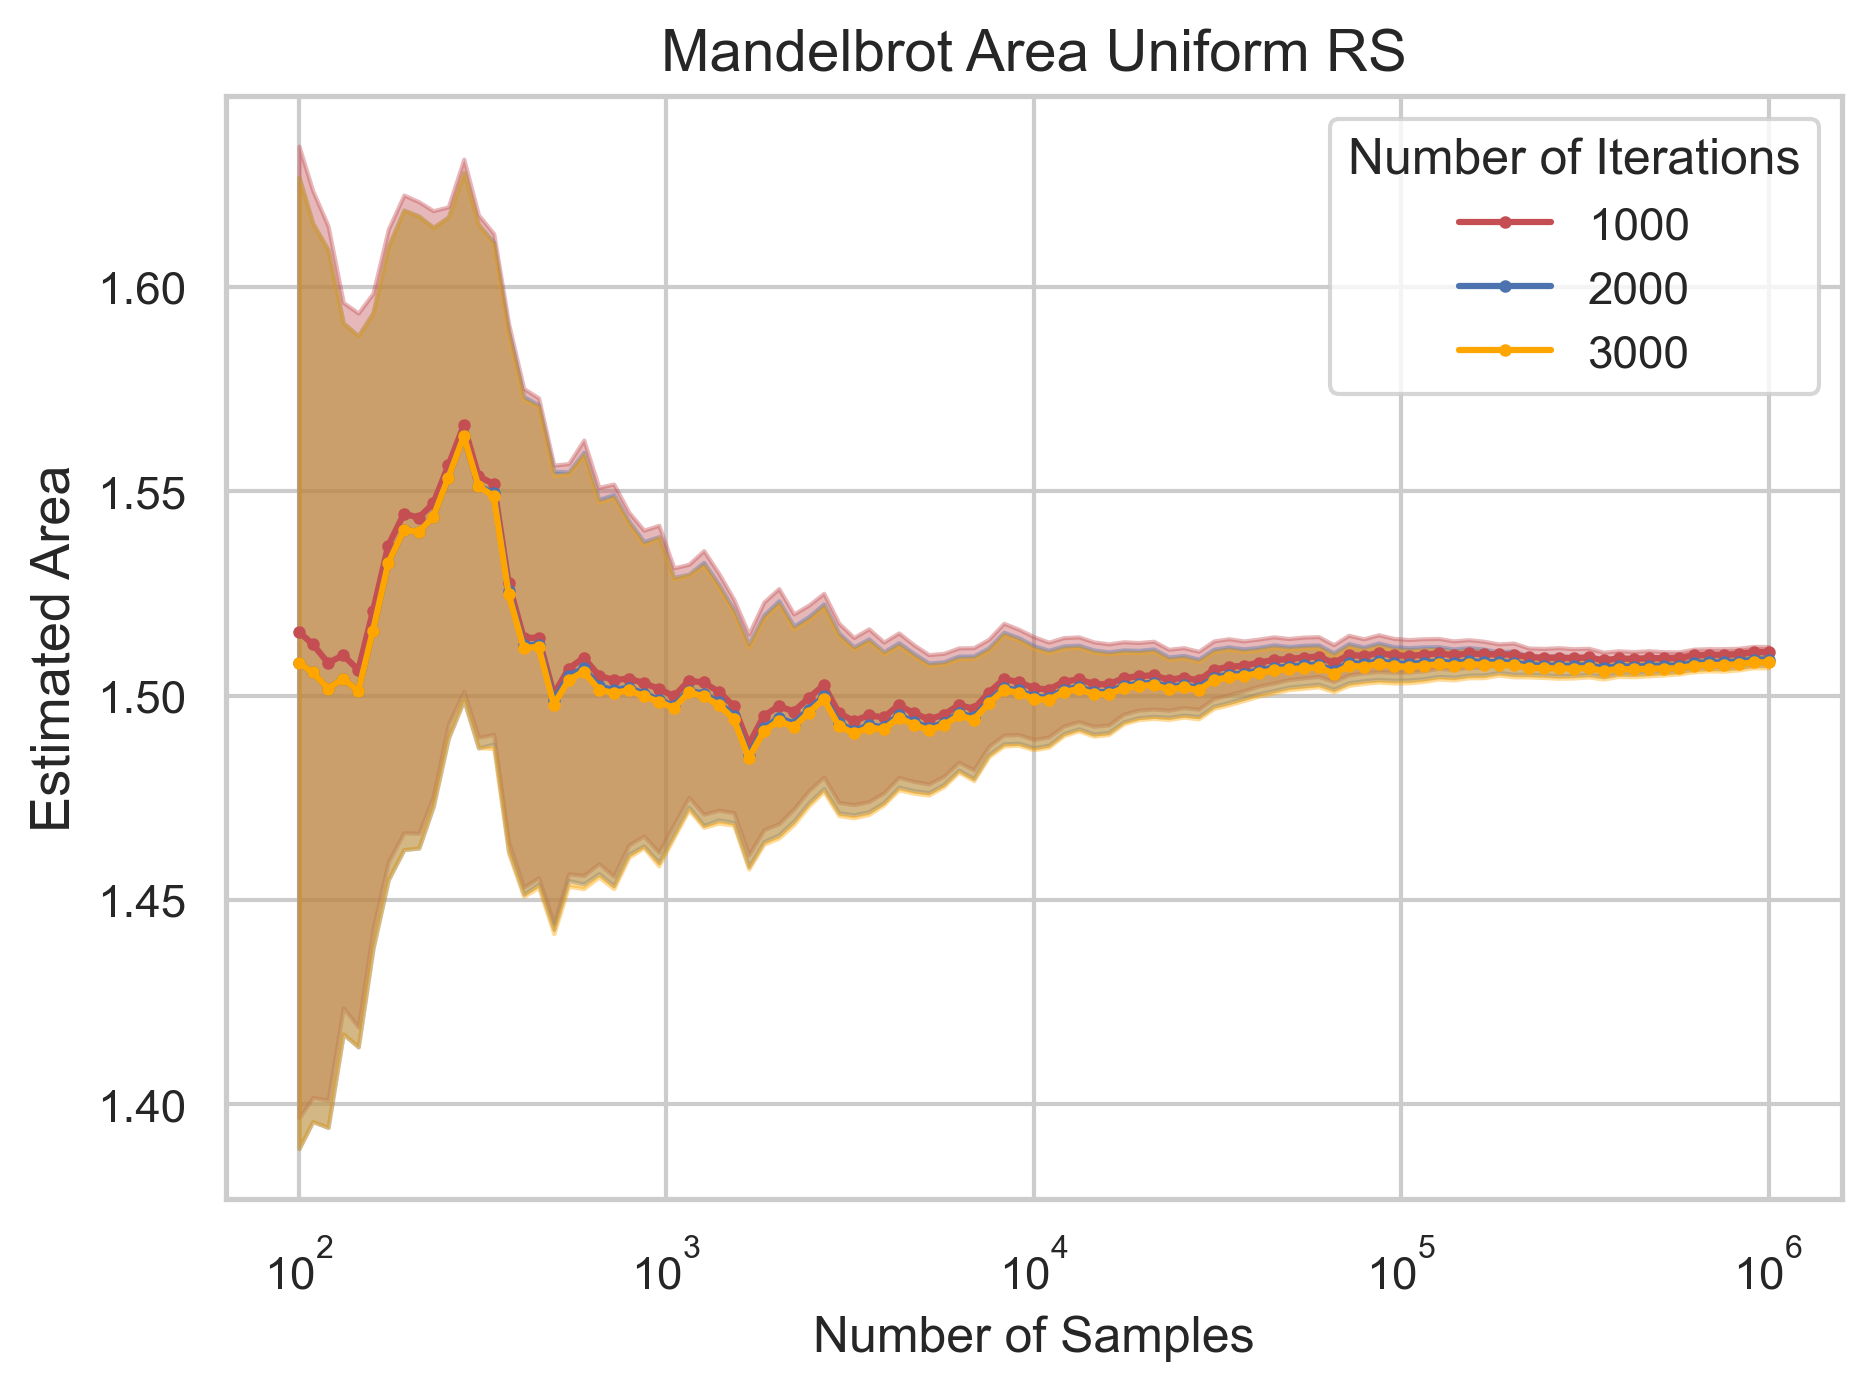

In [ ]:
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'RS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

Varying number of iterations with fixed samples size at $10^2$, $10^4$ and $10^6$.

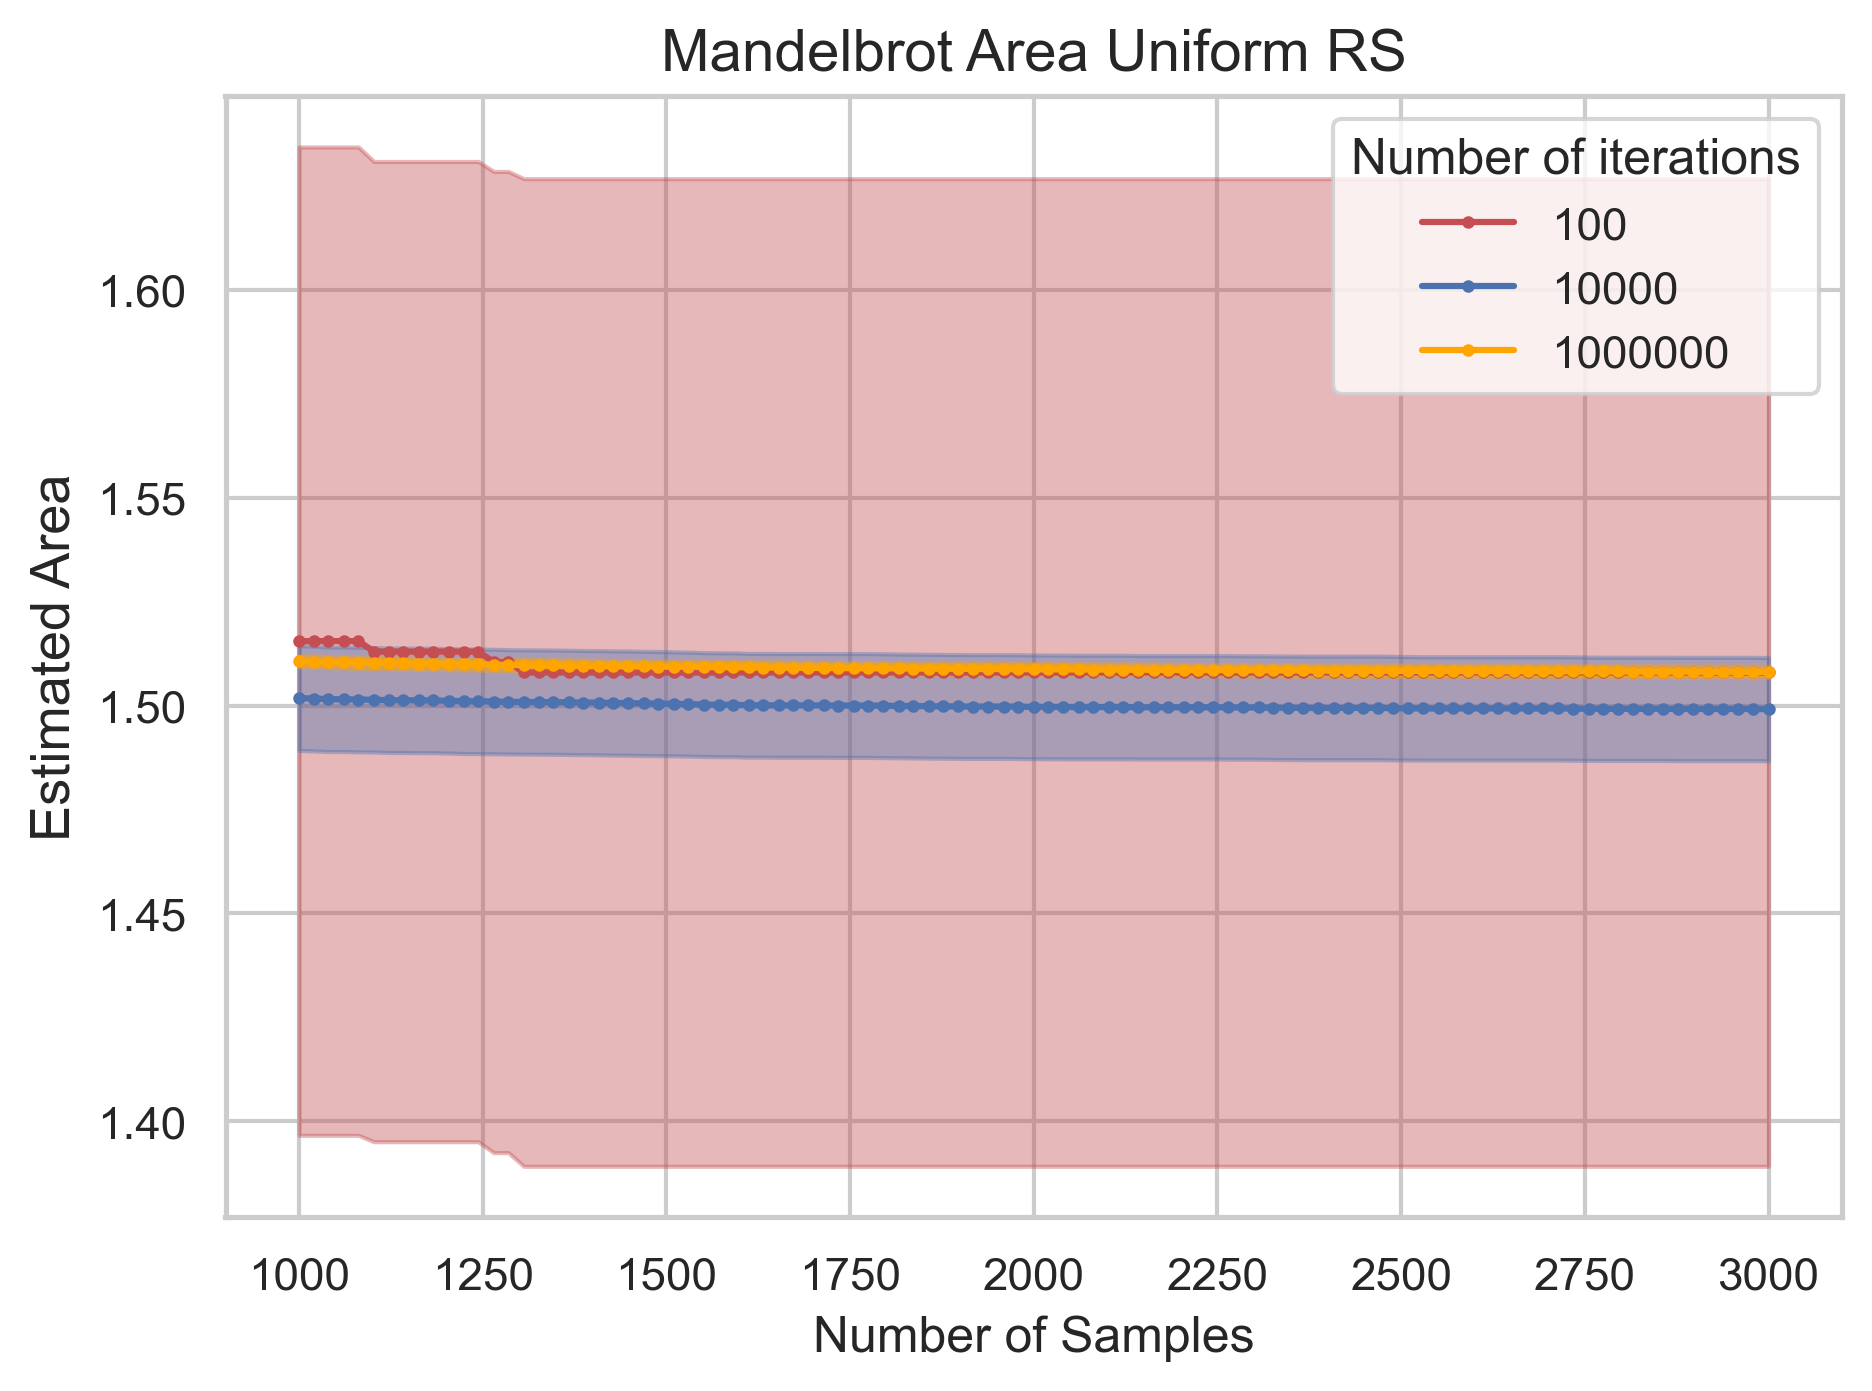

In [ ]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)
s_idx_10_power_4 = np.where(s_list_rs == 10**4)[0][0]
s_idxs = [0, s_idx_10_power_4, -1]

plot_lineplot(i_list, areas_rs[:, s_idxs], upper_rs[:, s_idxs], lower_rs[:, s_idxs], 'Number of iterations', s_list_rs[s_idxs], 'RS', log_x=False, fig_filename=f'vary_s_{num_s}_vary_i_{num_i}_{num_mc}_rs')

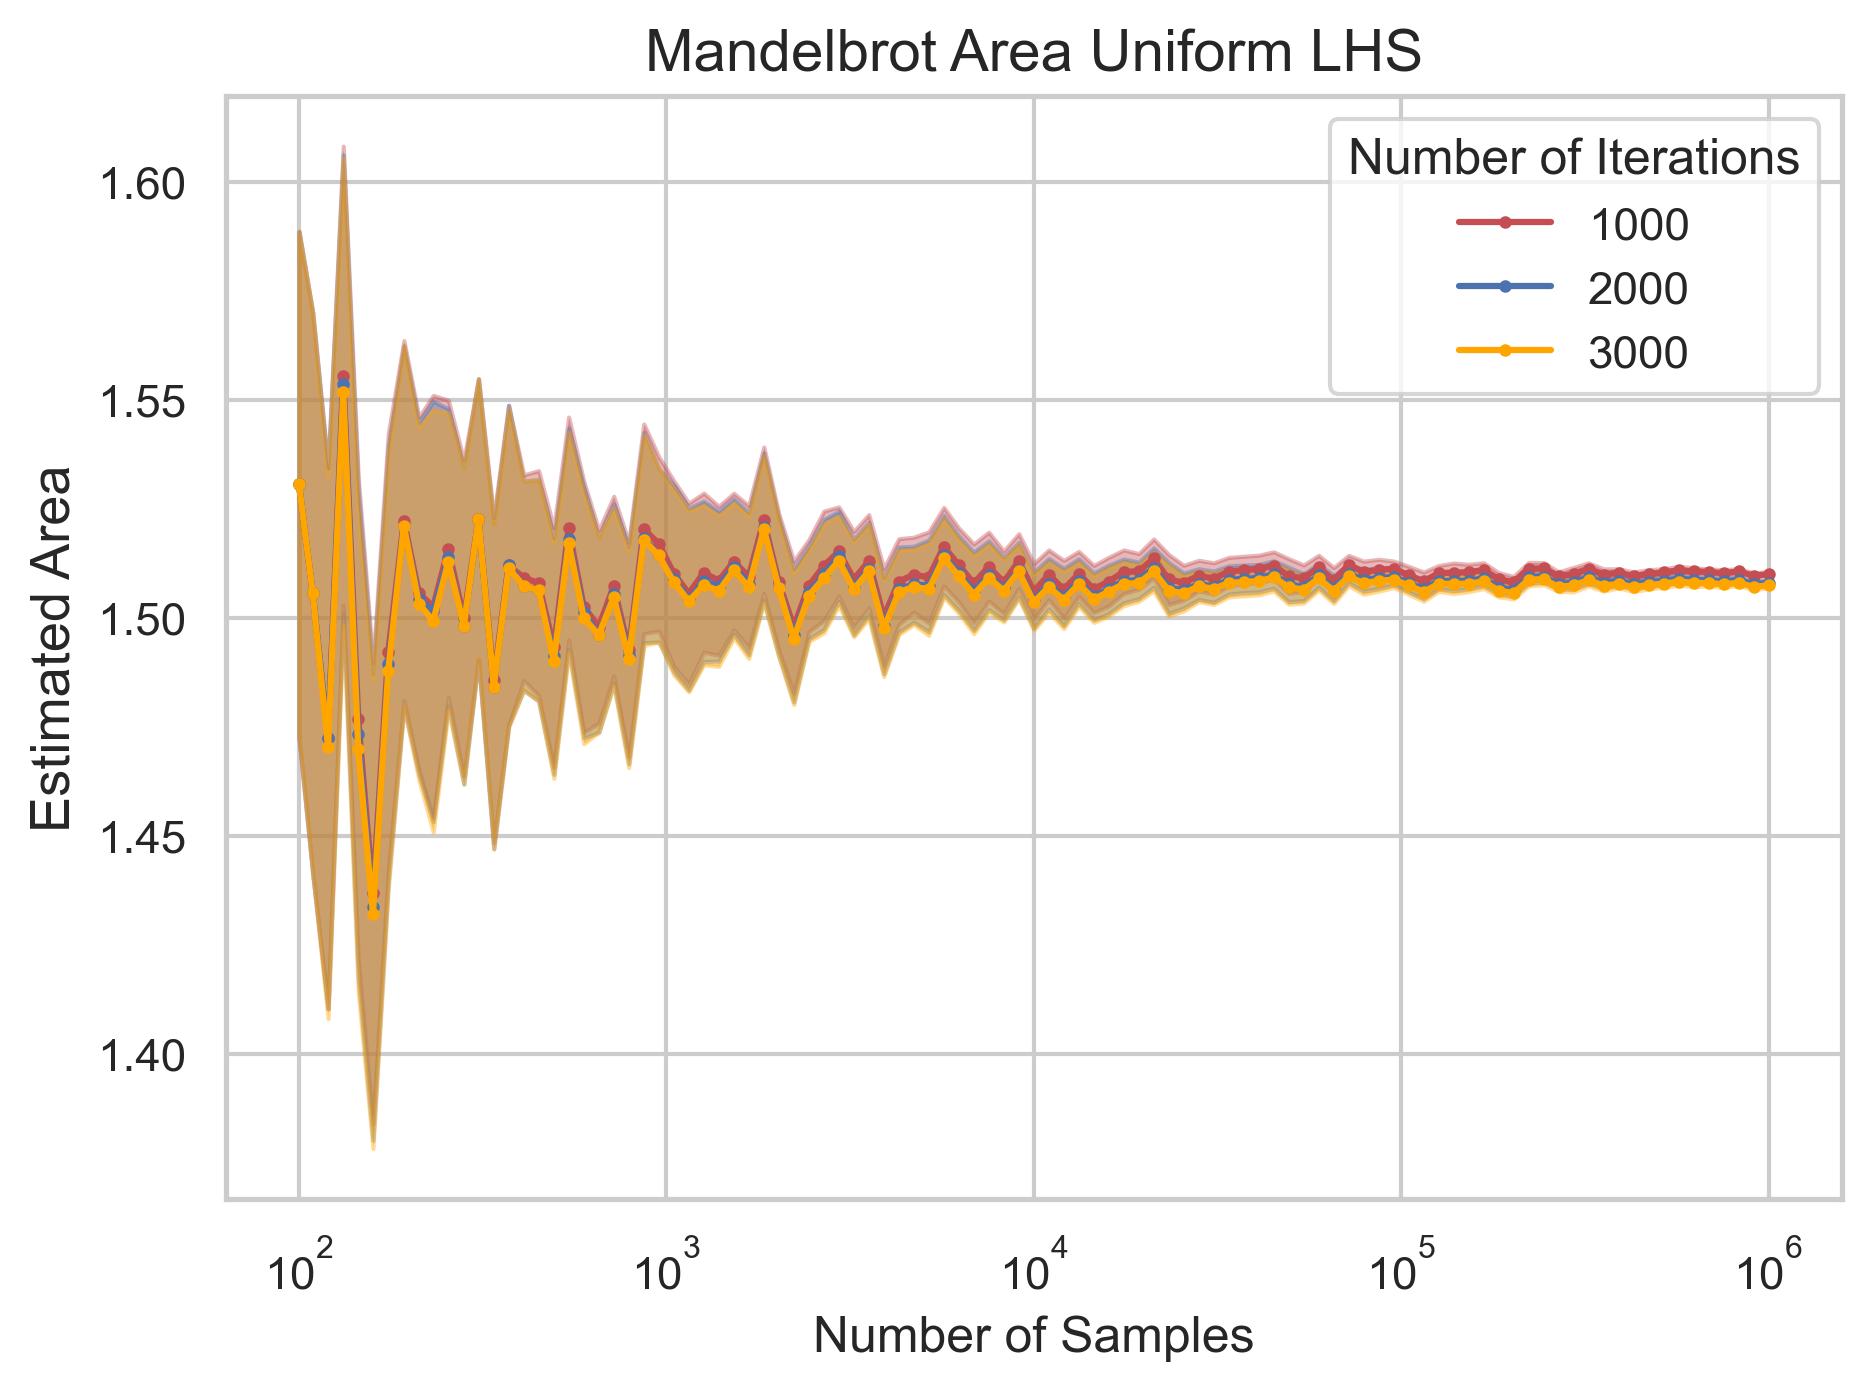

In [ ]:
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'LHS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

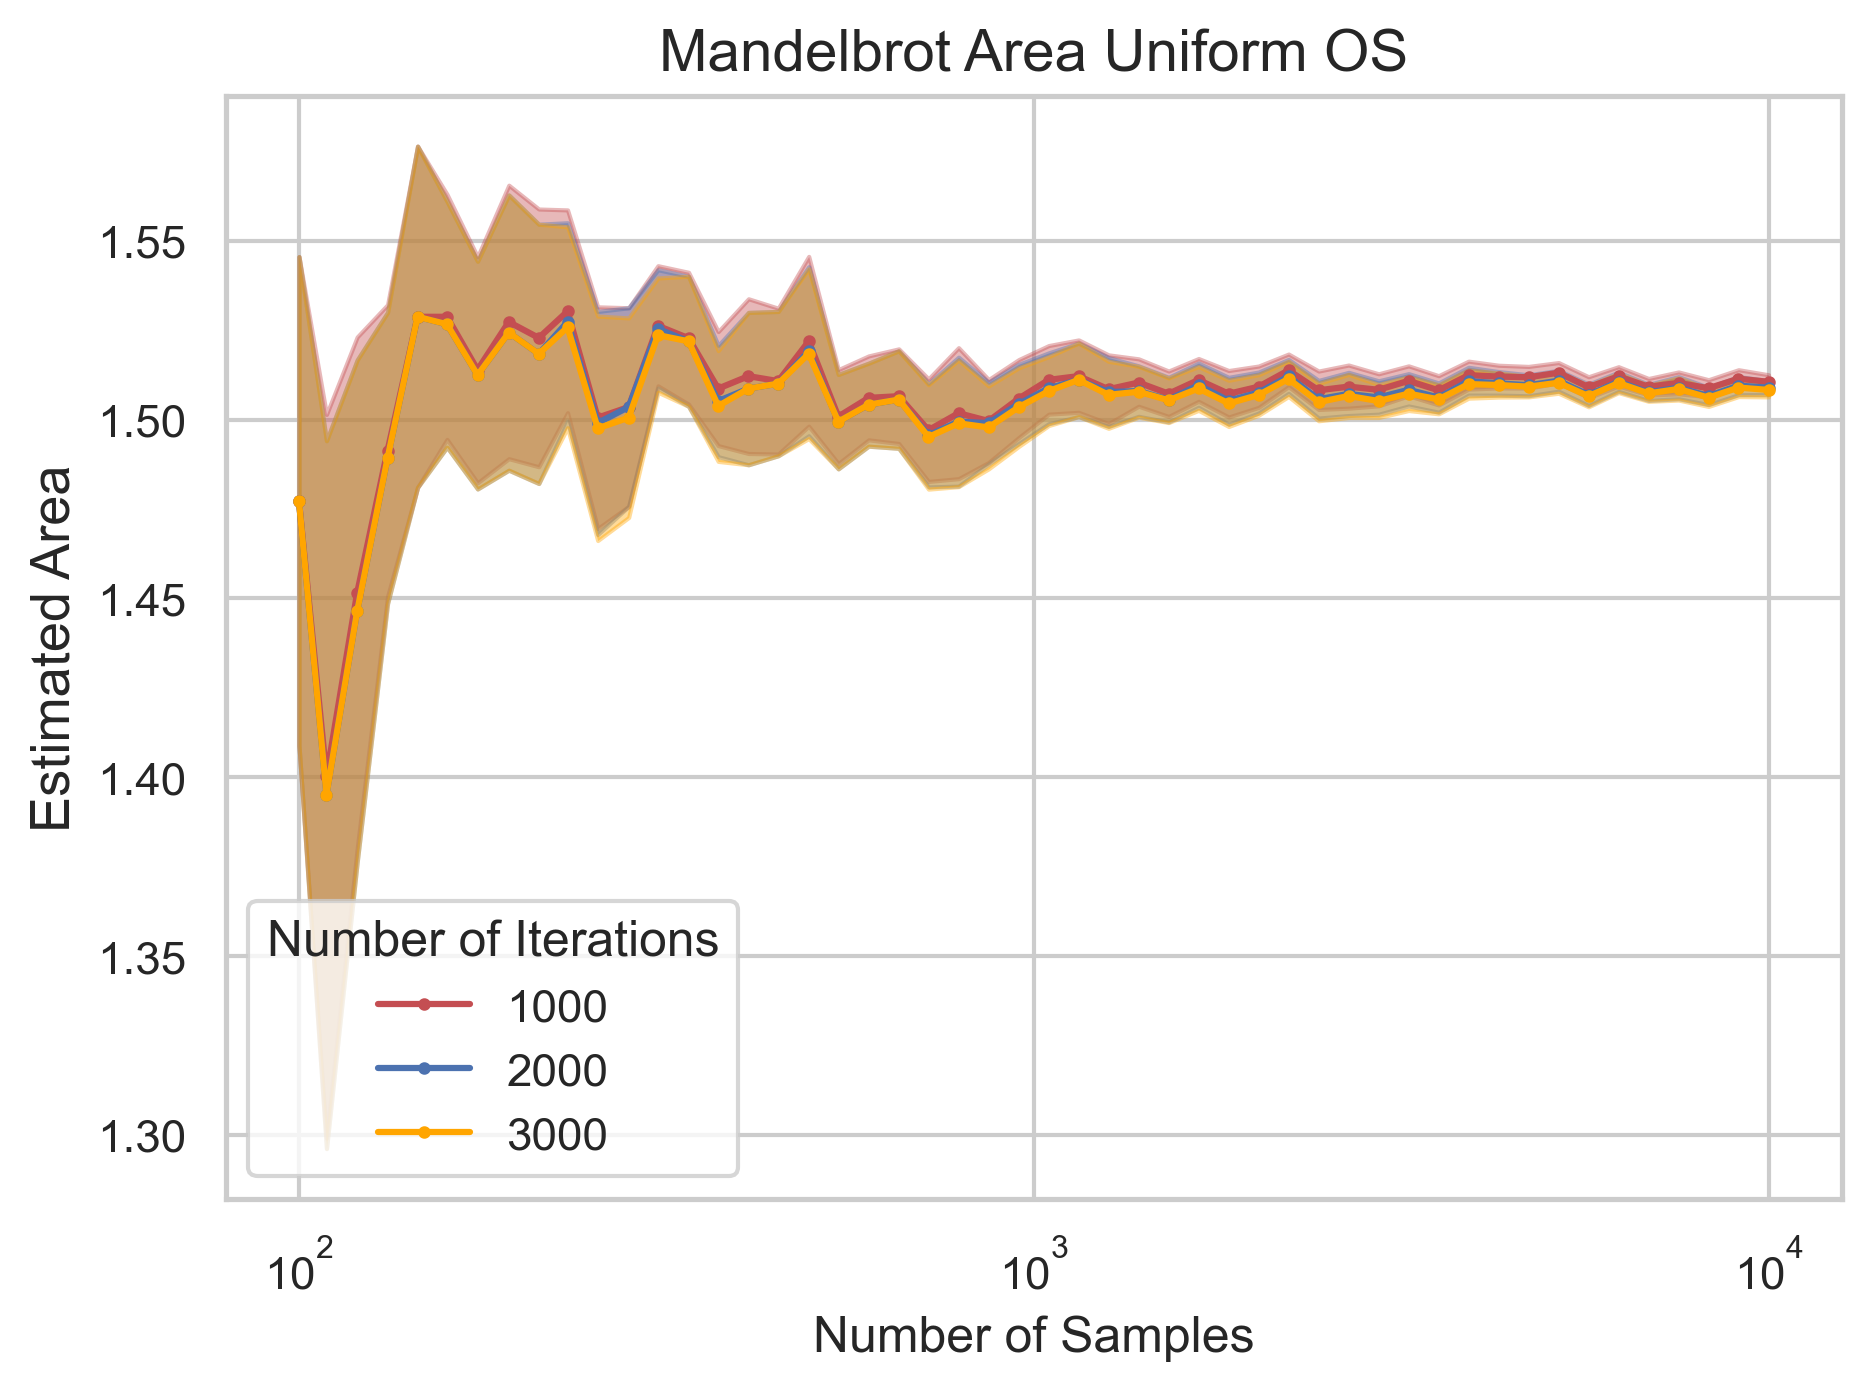

In [ ]:
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_os, areas_os[i_idxs, :], upper_os[i_idxs, :], lower_os[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'OS', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

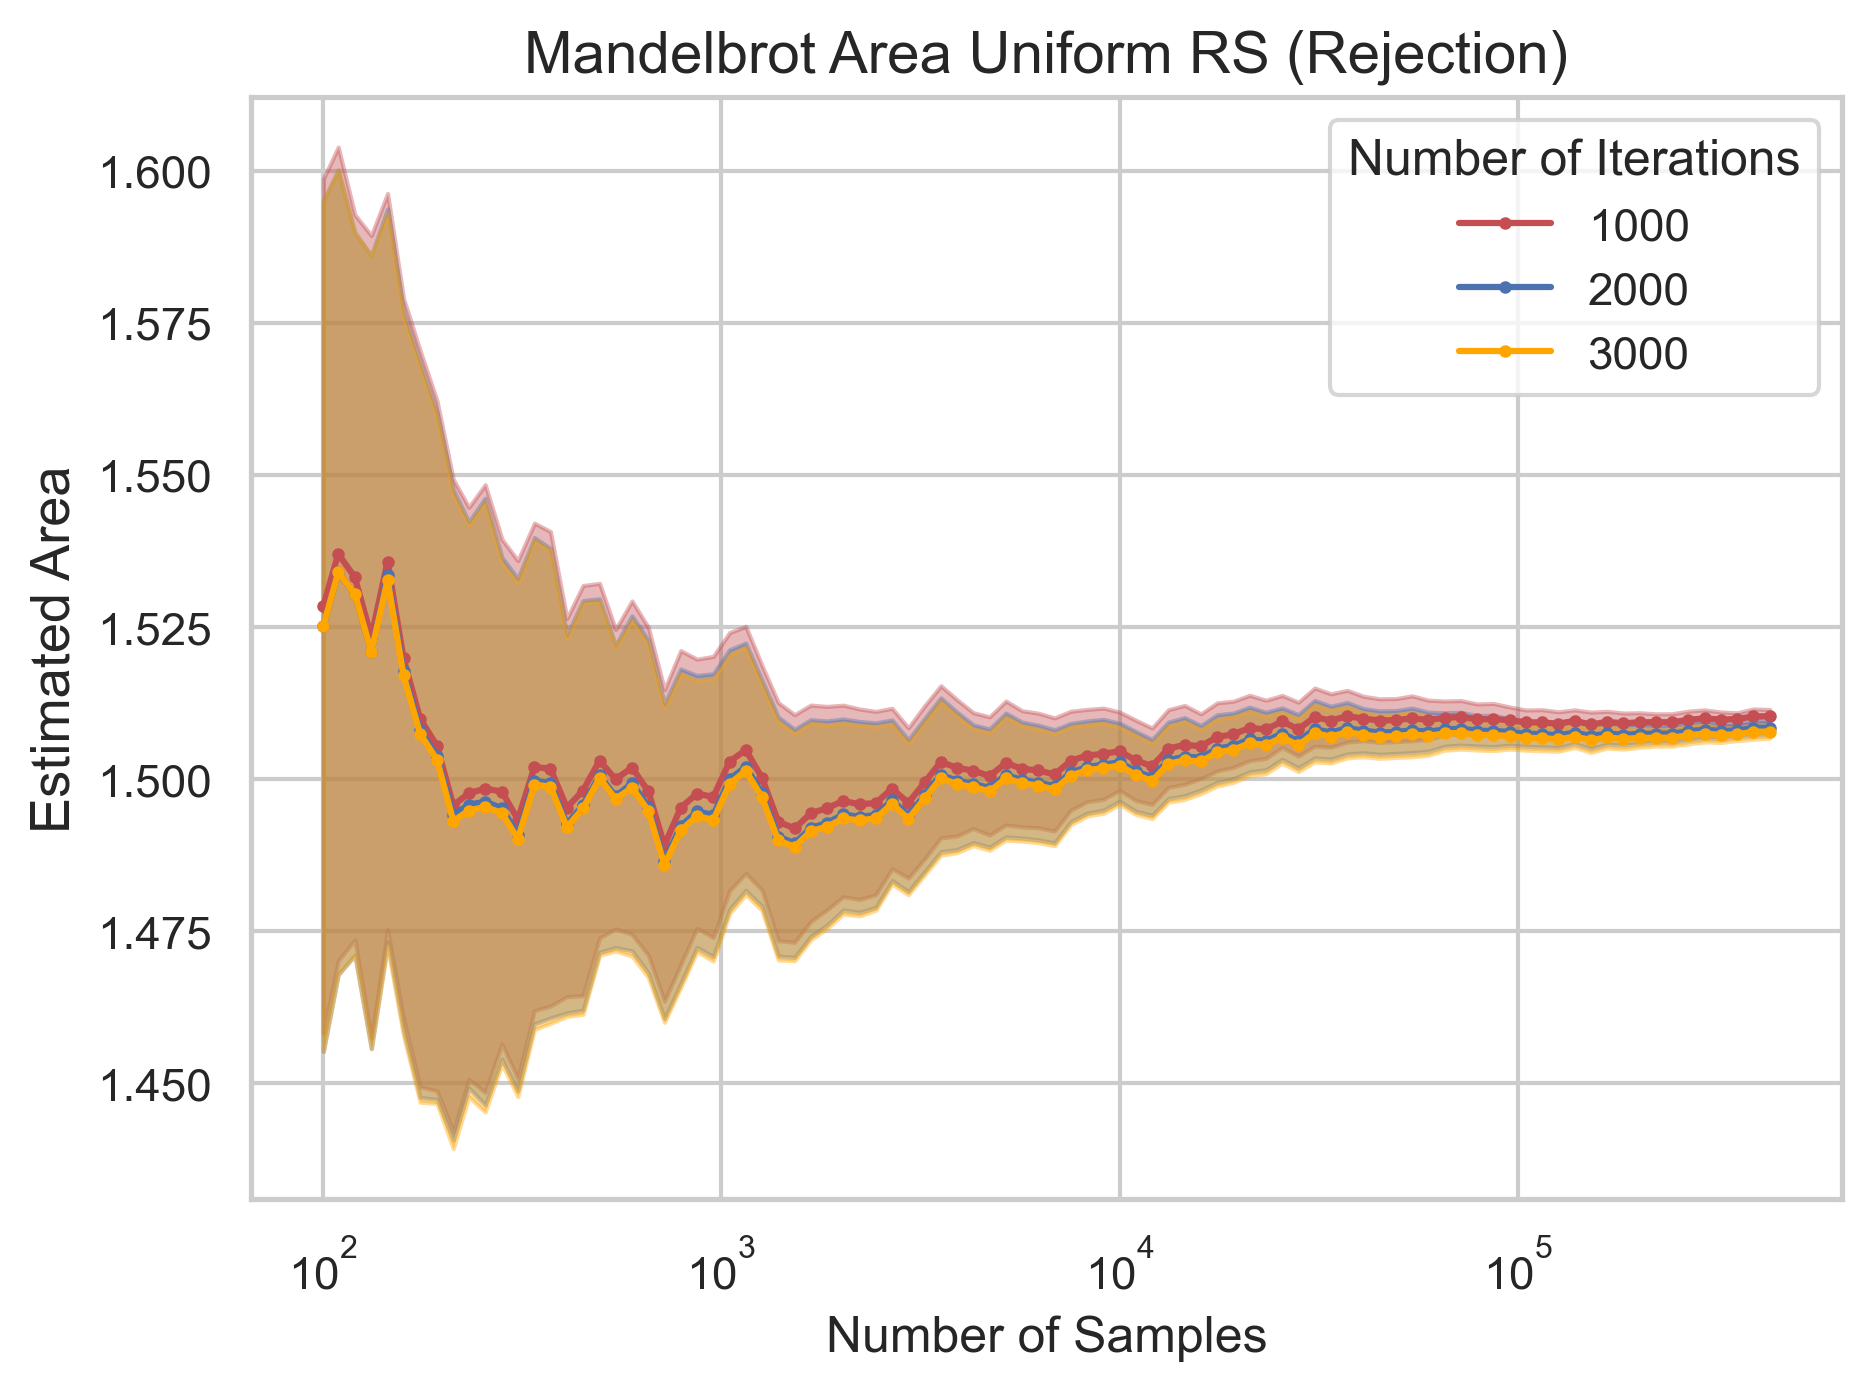

In [ ]:
# areas_rej, sd_rej, upper_rej, lower_rej, conv_i_list_rej, grid_rej = get_data_rejection_sampling_random(num_mc, i_list, s_list_rs, load_file=True)
i_2000_idx = np.where(i_list == 2000)[0][0]
i_idxs = [0, i_2000_idx, -1]

plot_lineplot(s_list_rs[:max_s_idx_acc], areas_acc[i_idxs, :], upper_ci_acc[i_idxs, :], lower_ci_acc[i_idxs, :], 'Number of Iterations', i_list[i_idxs], 'RS (Rejection)', fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

# Q2.3 Calculating RMSE and abusolue error

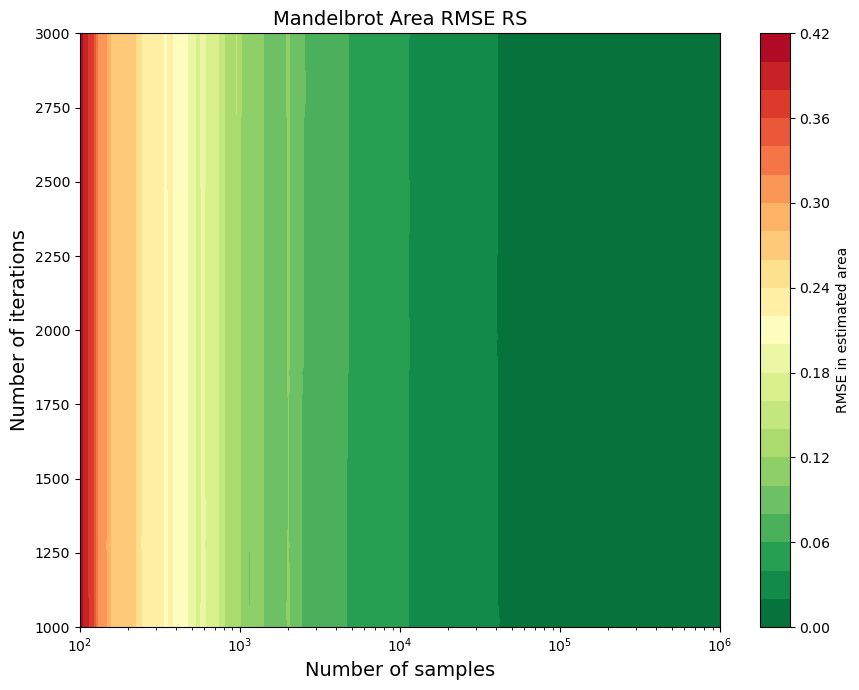

In [45]:
X,Y = np.meshgrid(s_list_rs, i_list)
plot_rmse_heatmap(X, Y, rmse_rs, 'RS')

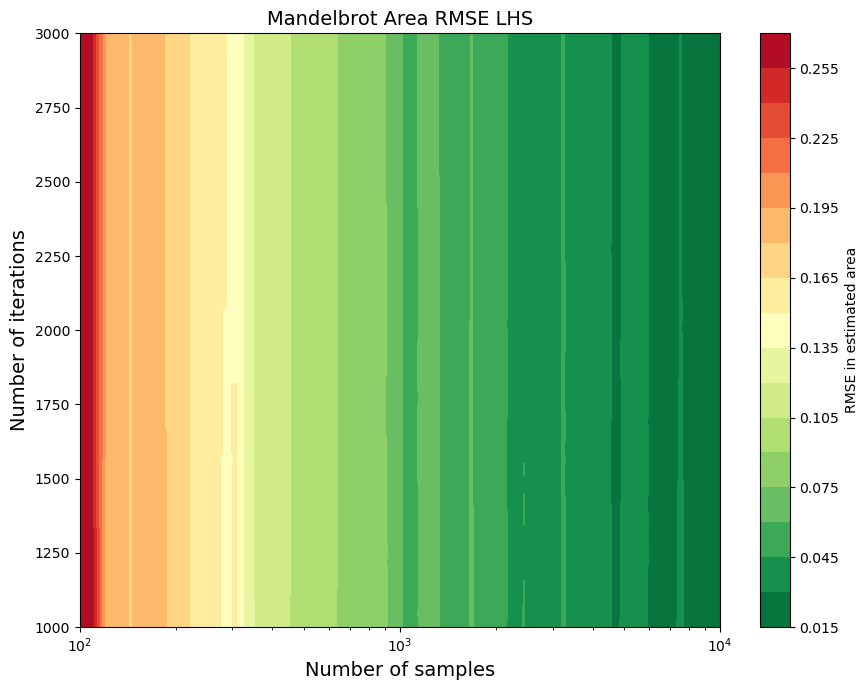

In [63]:
X,Y = np.meshgrid(s_list_lhs, i_list)
plot_rmse_heatmap(X, Y, rmse_lhs, 'LHS')

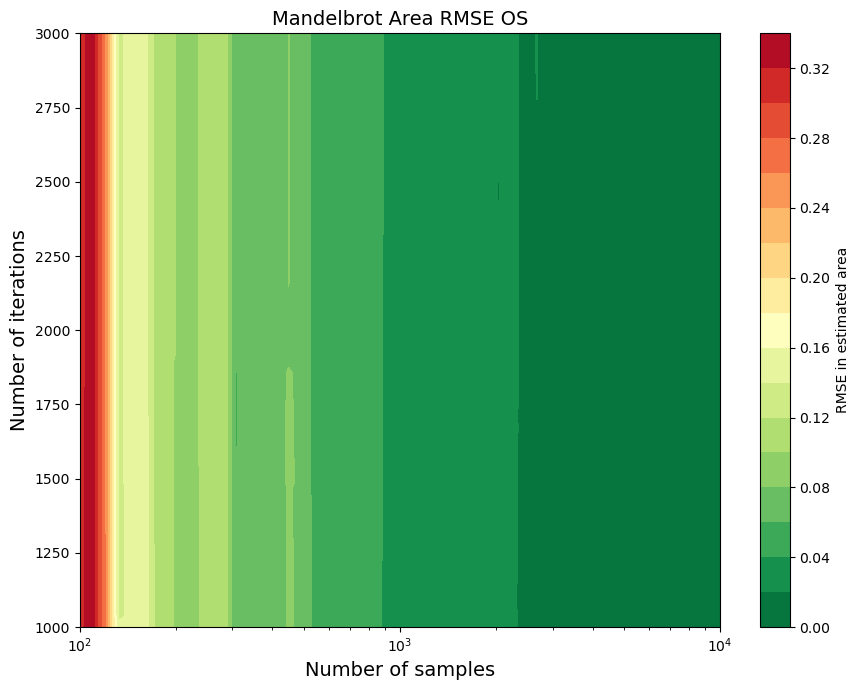

In [64]:
X,Y = np.meshgrid(s_list_os, i_list)
plot_rmse_heatmap(X, Y, rmse_os, 'OS')

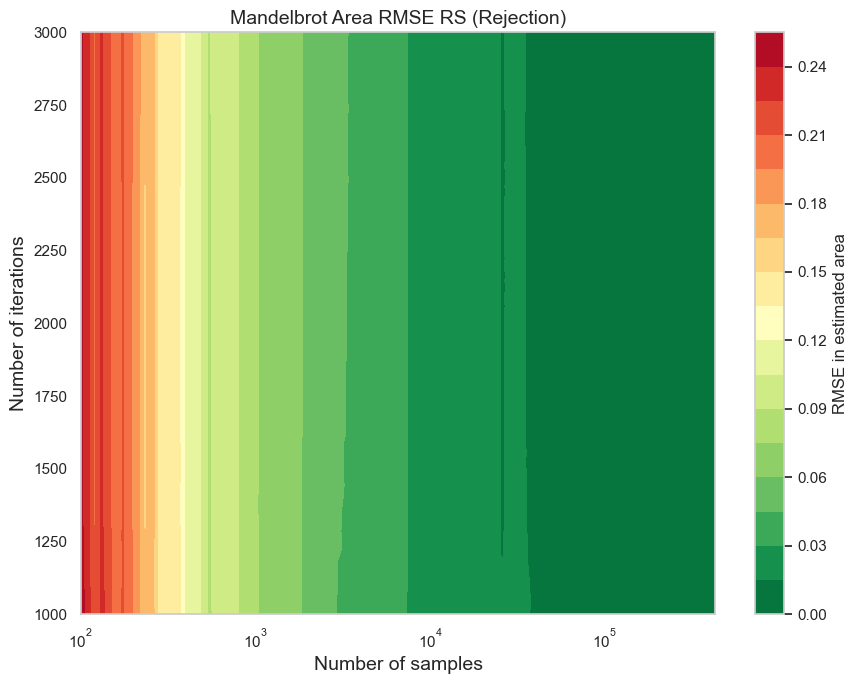

In [ ]:
X,Y = np.meshgrid(s_list_rs[:max_s_idx_acc], i_list)
plot_rmse_heatmap(X, Y, rmse_acc, 'RS (Rejection)')

Plot for absolute error

1.5081094896399905


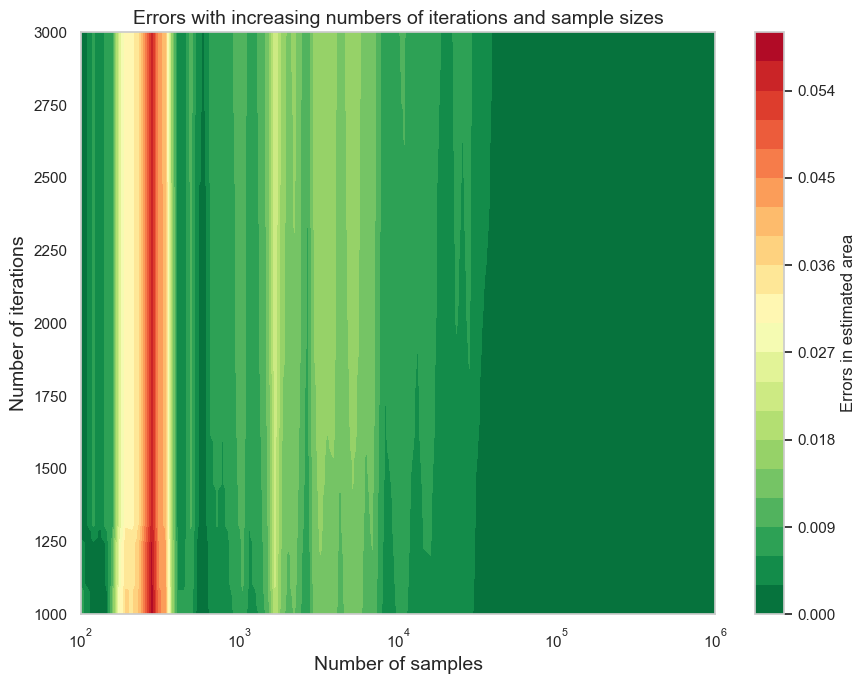

<Figure size 640x480 with 0 Axes>

In [ ]:
i_list = np.linspace(1000, 3000, num_i).astype(int)
s_list = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
true_area = areas_rs[-1, -1]
X,Y = np.meshgrid(s_list, i_list)
plot_heatmap(X,Y, areas_rs, true_area, fig_filename=f'heatmap_vary_s_{num_s}_vary_i_{num_i}_{num_mc}')

C:\Users\lishu\AppData\Local\Temp\ipykernel_14892\3559153436.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout after all subplots are created


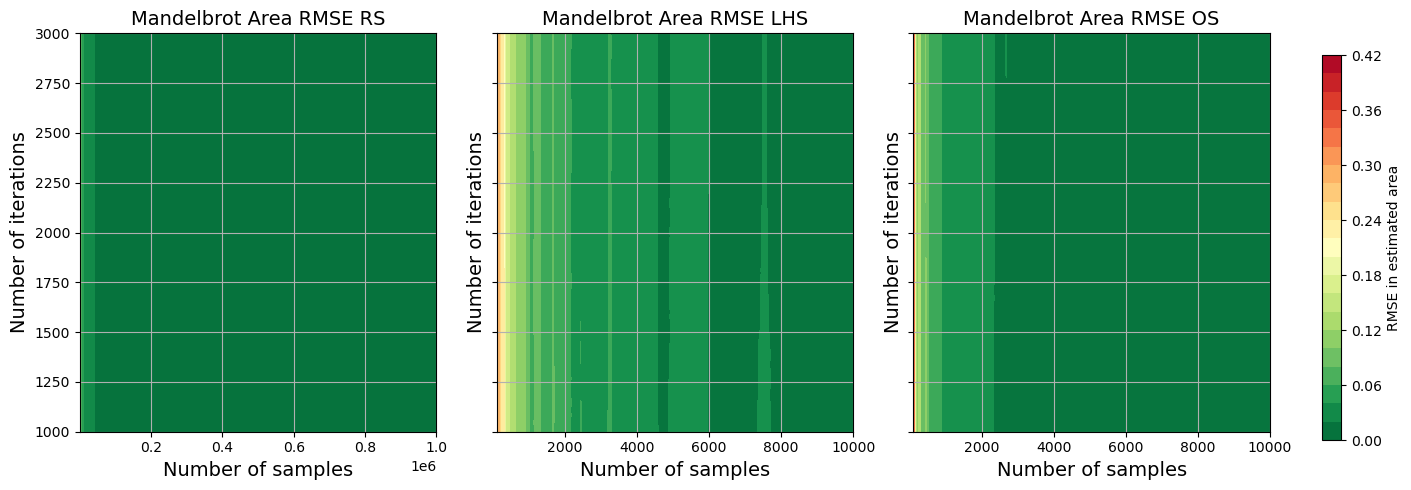

In [52]:
def plot_shared_contourf(X, Y, rmse, sampling_method, axs):
    contour = axs.contourf(X, Y, rmse, cmap='RdYlGn_r', levels=20)
    axs.set_title(f'Mandelbrot Area RMSE {sampling_method}', fontsize=14)
    axs.set_xlabel('Number of samples', fontsize=14)
    axs.set_ylabel('Number of iterations', fontsize=14)
    axs.grid()

    return contour

sampling_methods = ['RS', 'LHS', 'OS']
s_list_heatmap = [s_list_rs, s_list_lhs, s_list_os]
rmse_list = [rmse_rs, rmse_lhs, rmse_os]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for idx in range(3): 
#     X,Y = np.meshgrid(s_list_heatmap[idx], i_list)
#     axs[idx].contourf(X, Y, rmse_list[idx], cmap='RdYlGn_r', levels=20)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Share y-axis
contours = []
for idx in range(3): 
    X, Y = np.meshgrid(s_list_heatmap[idx], i_list)
    contours.append(plot_shared_contourf(X, Y, rmse_list[idx], sampling_methods[idx], axs[idx]))

cbar = fig.colorbar(contours[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('RMSE in estimated area')

plt.tight_layout()  # Adjust layout after all subplots are created


plt.subplots_adjust(right=0.85)

plt.show()  # Show the final figure with all subplots

# Q2.4 Hypothesis testing

In [68]:
def hypothesis_testing(areas, sd, true_area, num_mc, true_sd=None): 
    diff_area = (areas - true_area)
    sqrt_num_mc = np.sqrt(num_mc)
    if true_sd:
        dof = ((sd**2+true_sd**2)/num_mc)**2/(sd**4+true_sd**4/(num_mc*(num_mc-1)))
        t_statistics = (diff_area / np.sqrt(sd**2+true_sd**2)) * sqrt_num_mc
    else:
        t_statistics = (diff_area / sd) * sqrt_num_mc
        dof=num_mc-1

    p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistics), dof))

    return p_value

In [97]:
true_area = areas_rs[-1, -1]
true_sd = sd_rs[-1,-1]
p_value_rs = hypothesis_testing(areas_rs, sd_rs, true_area, num_mc)
p_value_lhs = hypothesis_testing(areas_lhs, sd_lhs, true_area, num_mc)
p_value_os = hypothesis_testing(areas_os, sd_os, true_area, num_mc)
p_value_acc = hypothesis_testing(areas_acc, sd_acc, true_area, num_mc)
Welch_rs = hypothesis_testing(areas_rs, sd_rs, true_area, num_mc, true_sd)

3D plot of the $p$-value with OR method

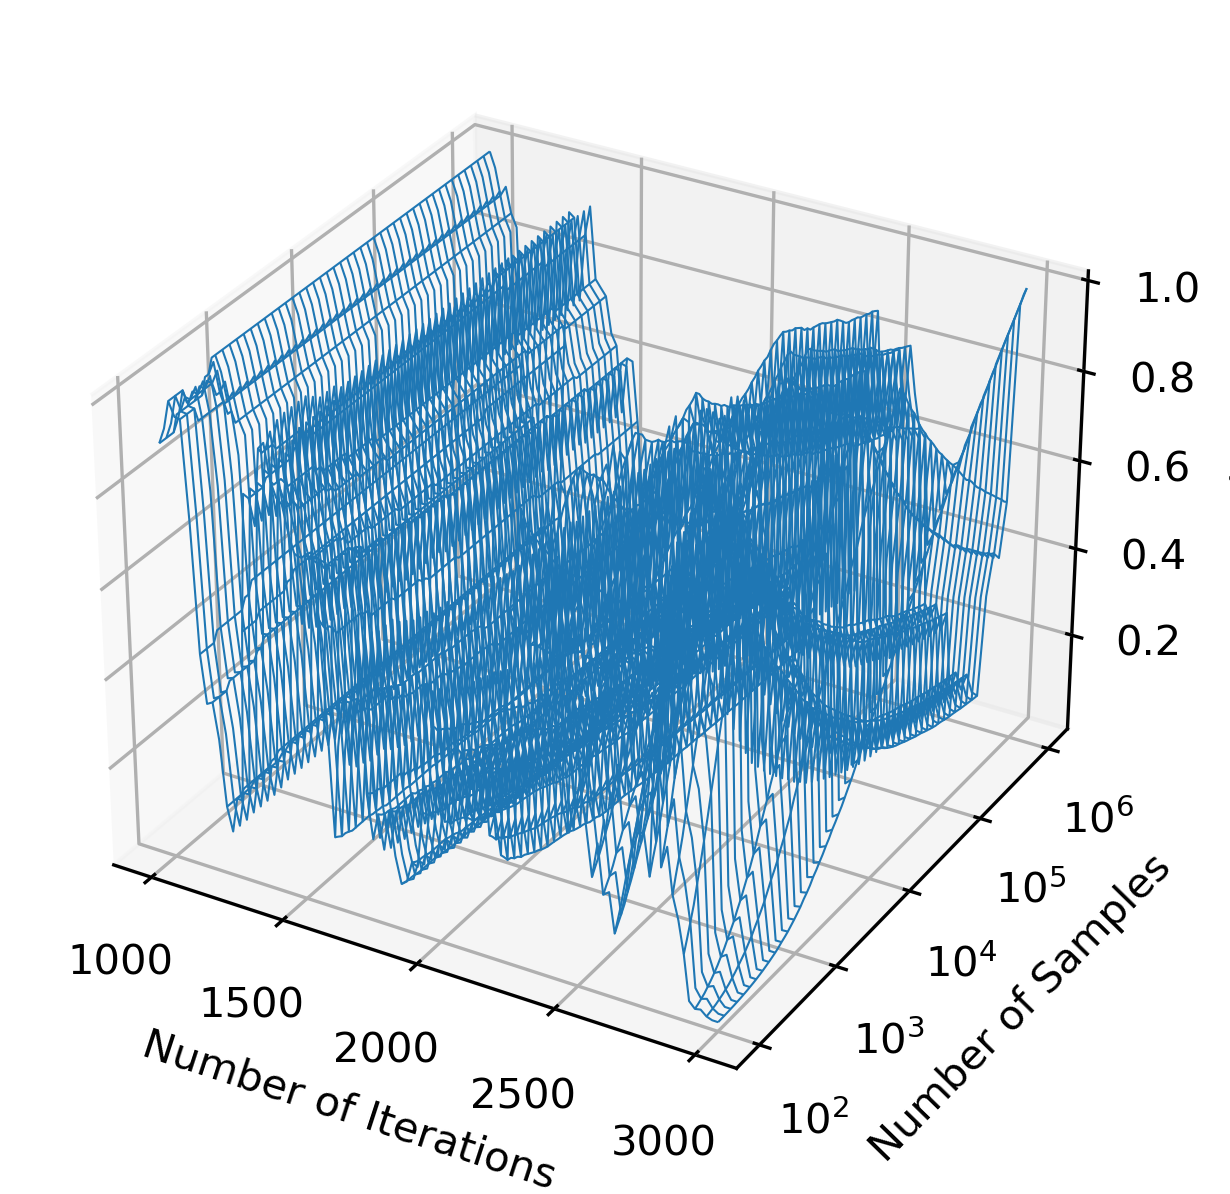

In [84]:
plot_3d(i_list, s_list_rs, p_value_rs)
#plot_3d(i_list, s_list, p_value_lhs)

In [101]:
def plot_heatmap_rmse(l_list, s_list, areas, sd, sampling_type, alpha=5, fig_filename=None):
    rmse = sd ** 2

    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(l_list, s_list, rmse, cmap=mycmap, levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='Errors in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title(fr'$p$-value of {sampling_type} with Various $i$ and $s$', fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

def plot_heatmap_pvalue(X, Y, p_value, sampling_type, alpha=5, fig_filename=None):
    # newcolors = plt.get_cmap('plasma_r',100).colors
    # newcolors[0:alpha, :] = colors.to_rgba('black')

    # mycmap = colors.ListedColormap(newcolors)
    # cmap = colors.ListedColormap(['black', 'plasma_r'])
    # bounds = [0, 0.05]
    # norm = mcolors.BoundaryNorm(bounds, cmap.N)
    cmap = plt.cm.plasma_r
    cmap.set_under('black')

    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, p_value, cmap=cmap, vmin=0.05, levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='$p$-value')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title(fr'$p$-value of {sampling_type}', fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

Heatmap of the $p$-value with OR method.

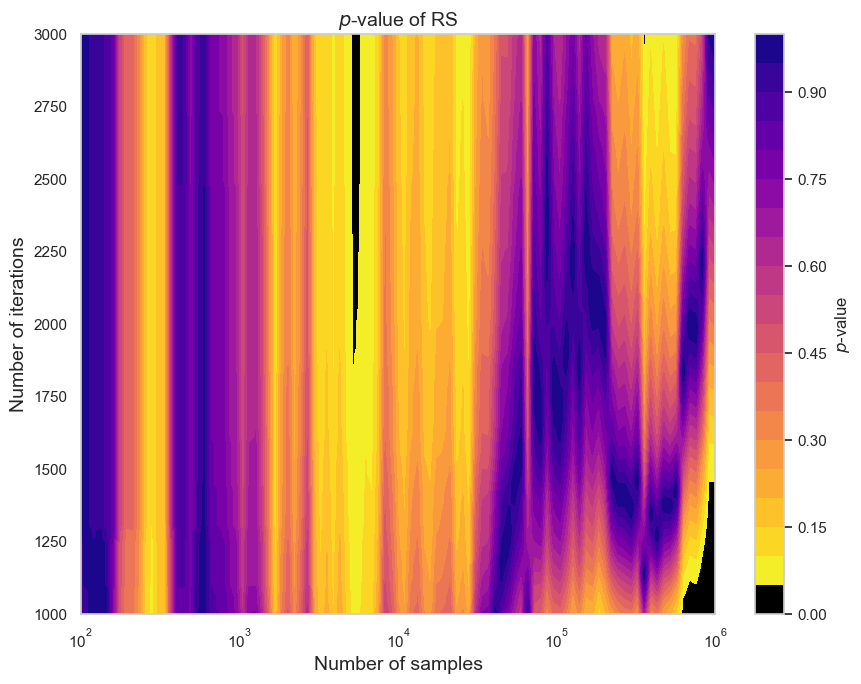

In [89]:
plot_heatmap_pvalue(s_list_rs, i_list, p_value_rs, 'RS')

Heatmap of the $p$-value with LHS method. 

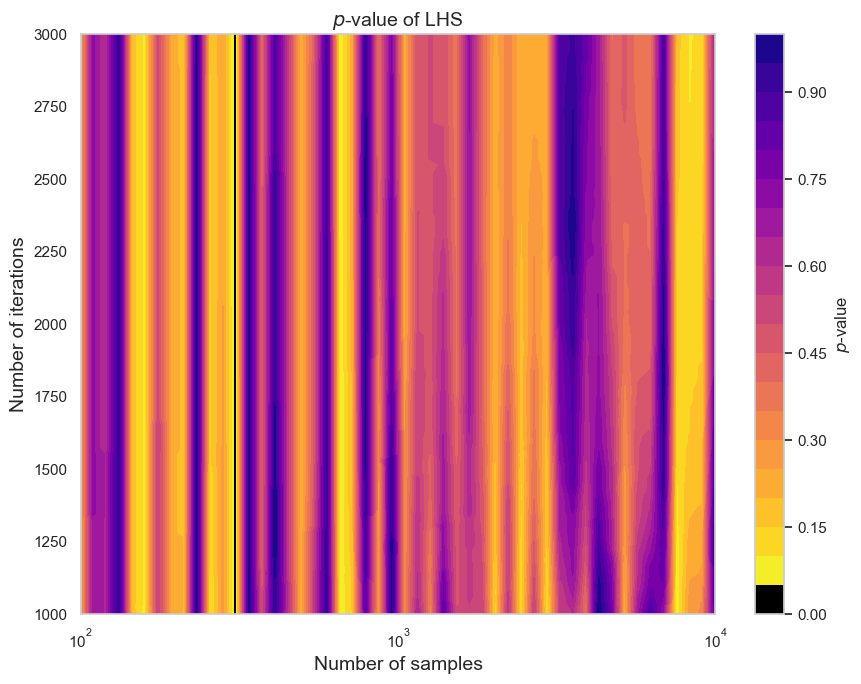

In [88]:
plot_heatmap_pvalue(s_list_lhs, i_list, p_value_lhs, 'LHS')

Heatmap of the $p$-value with OS method. 

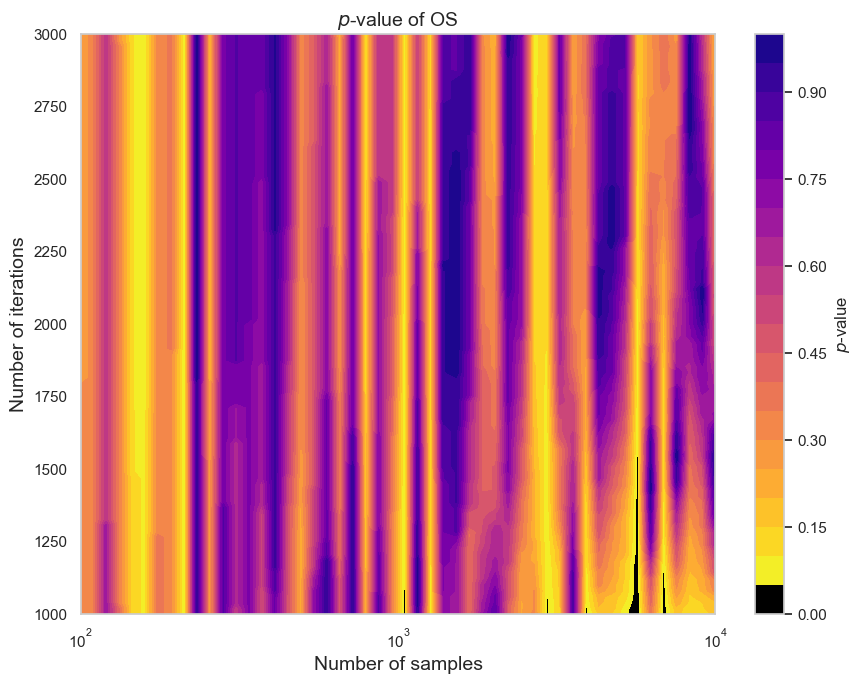

In [90]:
plot_heatmap_pvalue(s_list_os, i_list, p_value_os, 'OS')

Heatmap of the $p$-value with rejection sampling method.

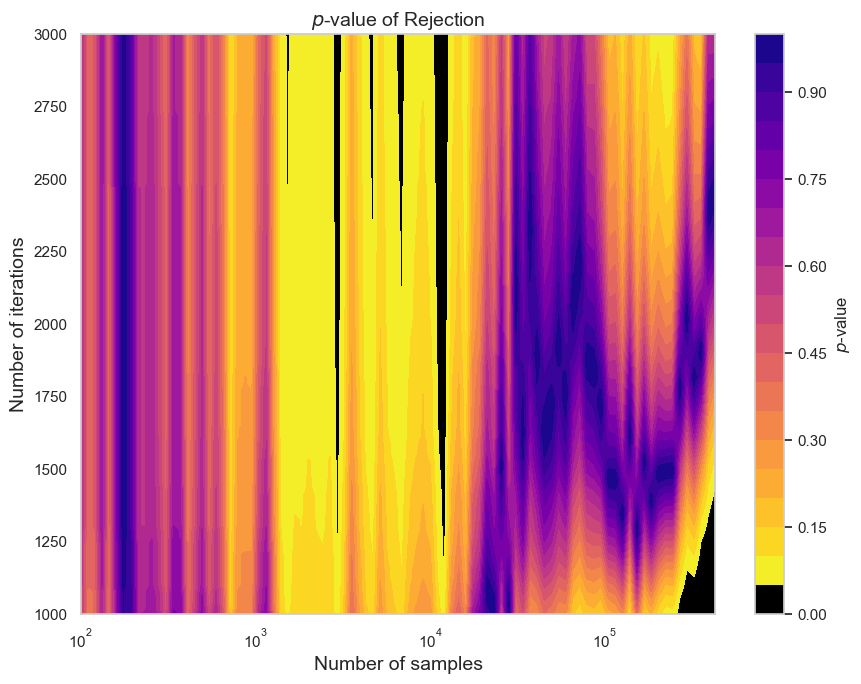

In [ ]:
plot_heatmap_pvalue(s_list_rs[:max_s_idx_acc], i_list, p_value_acc, 'RS (Rejection)', fig_filename=None)

Heatmap of the $p$-value with OR method using Welch t-test

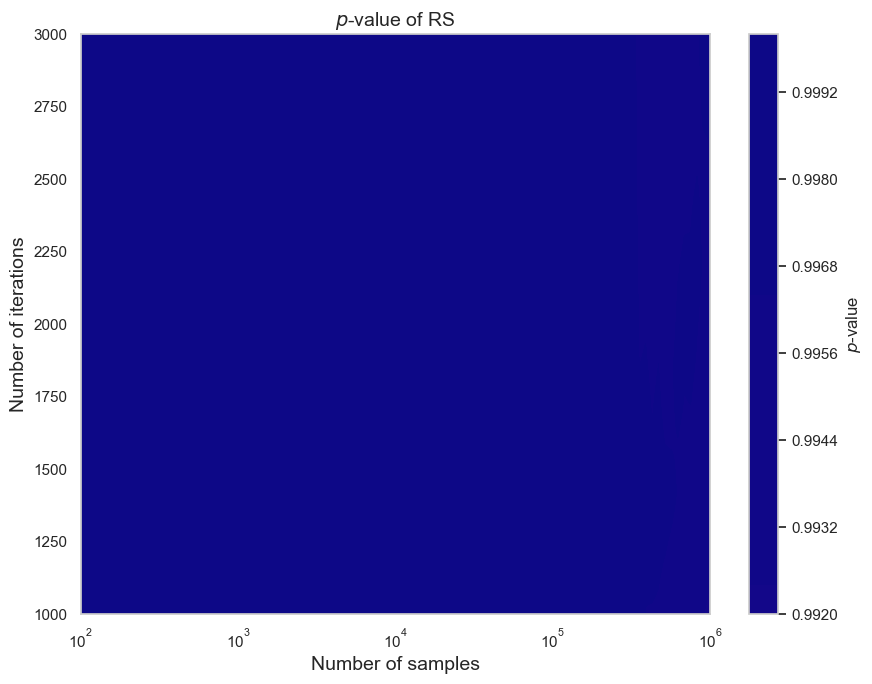

In [91]:
plot_heatmap_pvalue(s_list_rs, i_list, Welch_rs, 'RS')